# First Part


## getting audio signal in time domain


In [1]:
import matplotlib.pyplot as plt


def StreoToMono(Audiodata, showPlot=False):
    MonoAudio = Audiodata.sum(axis=1) / 2
    if showPlot:
        plt.plot(MonoAudio)
        plt.title("Audio signal in time", size=16)
    return MonoAudio


## spectrum calculation algorithm


In [2]:
import numpy as np
from scipy.fftpack import fft
from scipy.fft import fftshift



def calcSpectrum(MonoAudio, fs, showPlot=False, FreqRange=None):
    # discrete Fourier transform
    n = len(MonoAudio)
    AudioFreq = fft(MonoAudio)
    # Half of the spectrum(fft shift)
    AudioFreq = AudioFreq[0 : (n // 2 + 1)]
    # Magnitude
    MagFreq = np.abs(AudioFreq)
    # power spectrum
    MagFreq = MagFreq ** 2
    MagFreq /= float(fs * n)  # 1/T

    # adding negative free magnitudes to positive freq ones
    if n % 2 > 0:
        # fft odd: positive freqs and negative are the same numbers
        MagFreq[1 : len(MagFreq)] = MagFreq[1 : len(MagFreq)] * 2
    else:
        # fft even: positive freqs have one difference with negative freqs in numbers
        MagFreq[1 : len(MagFreq) - 1] = MagFreq[1 : len(MagFreq) - 1] * 2

    freqAxis = np.arange(0, fs / 2 + 1, fs / n)[0 : (n // 2 + 1)]

    if not FreqRange == None:
        rangeIndex = [0, 0]
        totalRange = np.abs(freqAxis[-1] - freqAxis[0])
        rangeIndex[0] = int((FreqRange[0] * len(freqAxis)) // totalRange)
        rangeIndex[1] = int((FreqRange[1] * len(freqAxis)) // totalRange)
        freqAxis = freqAxis[rangeIndex[0] : rangeIndex[1]]
        MagFreq = MagFreq[rangeIndex[0] : rangeIndex[1]]

    if showPlot:
        plt.plot(freqAxis, 10 * np.log10(MagFreq))
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power Spectrum Density (dB/Hz)")

    return freqAxis, MagFreq


## finding frequency with maximum power spectrum


In [3]:
def getMaxFreq(freqAxis, MagFreq, freqRange=(50, 300)):
    totalRange = np.abs(freqAxis[-1] - freqAxis[0])
    # just investigate the human speakable frequency domain
    rangeIndex = [0, 0]
    rangeIndex[0] = int((freqRange[0] * len(freqAxis)) // totalRange)
    rangeIndex[1] = int((freqRange[1] * len(freqAxis)) // totalRange)
    rangeIndex[1] = len(freqAxis) if len(freqAxis) < rangeIndex[1] else rangeIndex[1]
    max = rangeIndex[0]
    for i in range(rangeIndex[0], rangeIndex[1]):
        if MagFreq[i] > MagFreq[max]:
            max = i
    return freqAxis[max]


## tagging voices with detected gender

voice  0:  [211.02 HZ] female 
voice  1:  [110.43 HZ]   male 
voice  2:  [050.05 HZ]   male 
voice  3:  [131.32 HZ]   male 
voice  4:  [283.72 HZ] female 
voice  5:  [205.49 HZ] female 
voice  6:  [086.56 HZ]   male 
voice  7:  [181.34 HZ] female 
voice  8:  [149.90 HZ]   male 
voice  9:  [180.00 HZ] female 
voice 10:  [218.05 HZ] female 
voice 11:  [128.95 HZ]   male 


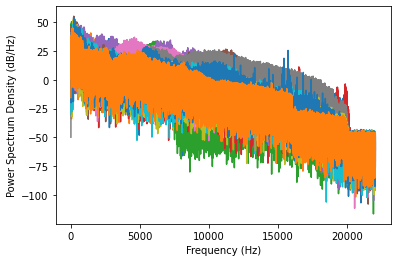

In [4]:
from scipy.io import wavfile


def maleOrFemale(AudioName):
    fs, Audiodata = wavfile.read(AudioName)
    freqAxis, MagFreq = calcSpectrum(StreoToMono(Audiodata), fs, showPlot=True)
    maxFreq = getMaxFreq(freqAxis, MagFreq)
    print("voice %2d:  [%06.2f HZ]" % (i, maxFreq), end=" ")
    if maxFreq > 300 or maxFreq < 50:
        raise Exception(
            "some non human speakable sound spectrum has most power spectrum density!"
        )
    elif maxFreq < 165:
        print("  male ")
    elif maxFreq > 180:
        print("female ")
    else:
        print("critical region 165-180")


for i in range(12):
    AudioName = "voices/v" + str(i) + ".wav"
    maleOrFemale(AudioName)


# Second Part


## reading audio file


In [5]:
from scipy.io import wavfile
import numpy as np

AudioName = "Test.wav"
fs, Audiodata = wavfile.read(AudioName)
# Audiodata = Audiodata.astype(float)
# Audiodata /= float(2 ** 15)  ## normalizing data


## awgn noise generator


In [6]:
from numpy.random import standard_normal


def awgn(signal, fs, SNRdB, L=1):
    """
        Parameters:
            SNR:  signal to noise ratio
    SNRdB=PsdB-PndB or SNR=Ps/Pn
    so noise with more power than
    signal lead to negative SNRdB
            L : oversampling factor
            (applicable for waveform
            simulation)
    """
    # SNR to linear scale(SNRdB to SNR)
    snr = 10 ** (SNRdB / 10)
    # Actual power in the vector
    signalPower = L * np.sum(abs(signal) ** 2) / len(signal) * fs
    # Find the noise spectral density
    noisePower = signalPower / snr
    # generat noise in standard normal distribution
    noise = np.sqrt(noisePower / 2) * standard_normal(signal.shape)
    # signal with noise
    noisySignal = signal + noise 

    return noisySignal


## investigating original signal, noisy signal, and noise


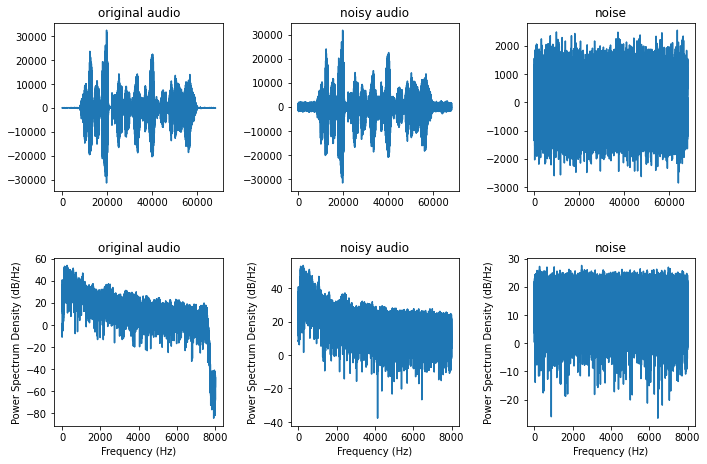

In [7]:
noisyAudio = awgn(Audiodata, fs, 15, 1)
fig = plt.figure(figsize=(10, 7))
plt.subplots_adjust(left=0.01, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.add_subplot(2, 3, 1)
plt.plot(Audiodata)
plt.title("original audio")

fig.add_subplot(2, 3, 2)
plt.plot(noisyAudio)
plt.title("noisy audio")

fig.add_subplot(2, 3, 3)
plt.plot(noisyAudio - Audiodata)
plt.title("noise")

# spectrum
fig.add_subplot(2, 3, 4)
calcSpectrum(Audiodata, fs, True, FreqRange=None)
plt.title("original audio")

fig.add_subplot(2, 3, 5)
calcSpectrum(noisyAudio, fs, True, FreqRange=None)
plt.title("noisy audio")

fig.add_subplot(2, 3, 6)
calcSpectrum(noisyAudio - Audiodata, fs, True, FreqRange=None)
plt.title("noise")

wavfile.write("Test Noise.wav", fs, noisyAudio.astype(np.int16))


## spectral substraction


### naive method


C:\Users\Mhmd_\AppData\Local\Temp\ipykernel_2052\2150210233.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqAxis, 10 * np.log10(MagFreq))


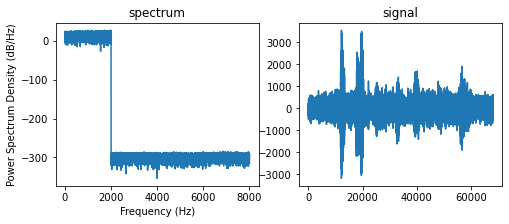

In [8]:
import scipy as sp
from scipy.signal import welch
from scipy.fft import ifftshift
from scipy.fft import ifft


def restrictSpectrum(originalAudio, fs, fc):
    ff = fftshift(fft(originalAudio))
    n = len(ff)
    # two sided spectrum
    specPower = (np.absolute(ff) ** 2) / (n * fs)
    # cut the frquency
    index = int(fc * n / fs)
    specPower[index + 1 : n - index + 1] = 0
    # filtering ended
    amplitude = np.sqrt(specPower * n * fs)
    signal = ifft(amplitude * np.exp(np.angle(ifftshift(ff)) * 1j))
    return np.real(signal)


fc = 2000
DeNoisedSignal = restrictSpectrum(noisyAudio, fs, fc)
wavfile.write("Test DeNoise 1.wav", fs, DeNoisedSignal.astype(np.int16))
fig2 = plt.figure(figsize=(8, 3))
fig2.add_subplot(1, 2, 1)
plt.title("spectrum")
calcSpectrum(DeNoisedSignal, fs, showPlot=True)
fig2.add_subplot(1, 2, 2)
plt.title("signal")
plt.plot(DeNoisedSignal)


### by low pass filter, slight cut

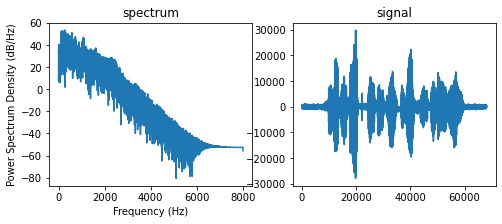

In [9]:
from scipy.signal import butter, lfilter, freqz


# coeficients of filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # plt.plot(b/a)
    return b, a
# affect low pass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

FilteredSignal = butter_lowpass_filter(noisyAudio, fc, fs)
wavfile.write("Test FilteredDeNoise 1.wav", fs, FilteredSignal.astype(np.int16))
fig2 = plt.figure(figsize=(8, 3))
fig2.add_subplot(1, 2, 1)
plt.title("spectrum")
calcSpectrum(FilteredSignal, fs, showPlot=True)
fig2.add_subplot(1, 2, 2)
plt.title("signal")
plt.plot(FilteredSignal)

### windowing method(real time method)

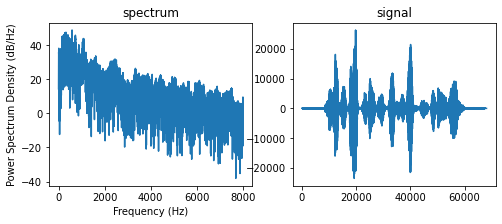

In [10]:
import scipy as sp
from scipy.signal import welch
from scipy.fft import ifft

ratio = 1
coefficient = 5.0
winsize = 2 ** 10
window = np.hanning(winsize)


def denoiseWindowByNoisePow(signal, noisePow):
    signalSpec = fft(signal * window)
    signalPhase = np.angle(signalSpec)
    signalAmp = np.absolute(signalSpec)
    signalPow = signalAmp ** 2.0
    # try to remove noise power
    newAmp = signalPow - noisePow * coefficient
    # amp = signalAmp ** 2.0 - (1 + np.std(noisePow) / noisePow) * noisePow * 2
    ## make sure power is not negative
    newAmp = np.maximum(newAmp, 0.01 * signalPow)
    newAmp = np.sqrt(newAmp)

    newAmp = ratio * newAmp + (1.0 - ratio) * signalAmp
    ff = newAmp * np.exp(signalPhase * 1j)
    return np.real(ifft(ff))


def getFrame(signal, no):
    shift = winsize // 2
    start = no * shift
    end = start + winsize
    return signal[start:end]


def addSignal(signal, frame, no):
    shift = winsize // 2
    start = no * shift
    end = start + winsize
    signal[start:end] = signal[start:end] + frame


DeNoisedSignal2 = np.zeros(len(noisyAudio), np.float32)
power = (
    welch(noisyAudio, window=window, return_onesided=False, scaling="spectrum")[1]
    * window.sum() ** 2
)

numberOfFrames = len(noisyAudio) // (winsize // 2) - 1
for frameNo in range(numberOfFrames):
    signalFrame = getFrame(noisyAudio, frameNo)
    addSignal(DeNoisedSignal2, denoiseWindowByNoisePow(signalFrame, power), frameNo)

wavfile.write("Test DeNoise 2.wav", fs, DeNoisedSignal2.astype(np.int16))
fig2 = plt.figure(figsize=(8, 3))
fig2.add_subplot(1, 2, 1)
plt.title("spectrum")
calcSpectrum(DeNoisedSignal2, fs, showPlot=True)
fig2.add_subplot(1, 2, 2)
plt.title("signal")
plt.plot(DeNoisedSignal2)



## final comarison

C:\Users\Mhmd_\AppData\Local\Temp\ipykernel_2052\2150210233.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqAxis, 10 * np.log10(MagFreq))


Text(0.5, 1.0, 'Original Audio PSD')

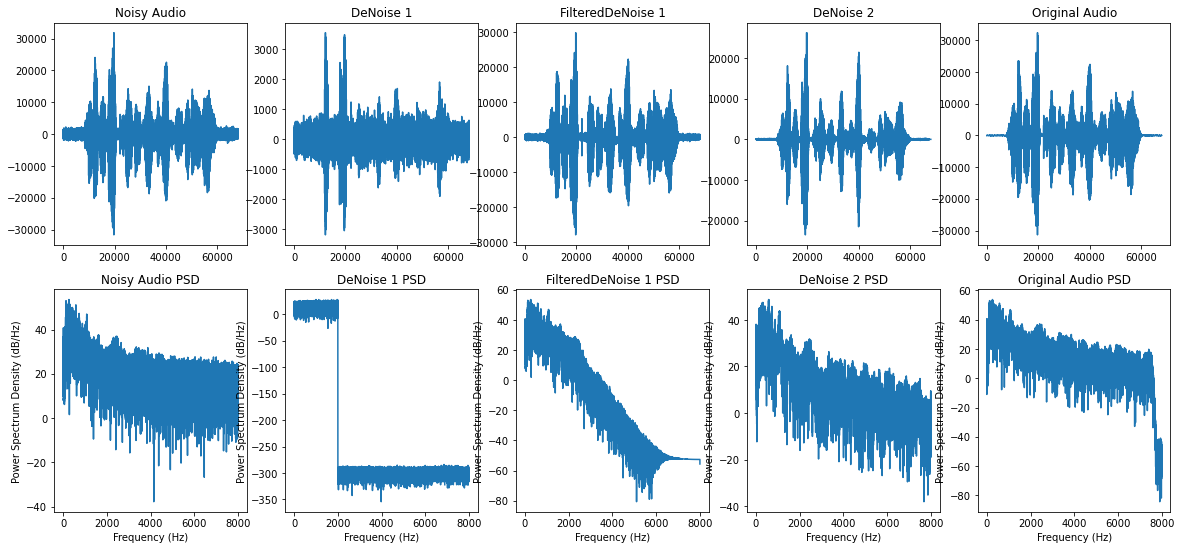

In [11]:
fig = plt.figure(figsize=(20, 9))

fig.add_subplot(2, 5, 1)
plt.plot(noisyAudio)
plt.title("Noisy Audio")

fig.add_subplot(2, 5, 2)
plt.plot(DeNoisedSignal)
plt.title("DeNoise 1")

fig.add_subplot(2, 5, 3)
plt.plot(FilteredSignal)
plt.title("FilteredDeNoise 1")

fig.add_subplot(2, 5, 4)
plt.plot(DeNoisedSignal2)
plt.title("DeNoise 2")

fig.add_subplot(2, 5, 5)
plt.plot(Audiodata)
plt.title("Original Audio")

fig.add_subplot(2, 5, 6)
calcSpectrum(noisyAudio, fs, True, FreqRange=None)
plt.title("Noisy Audio PSD")

fig.add_subplot(2, 5, 7)
calcSpectrum(DeNoisedSignal, fs, True, FreqRange=None)
plt.title("DeNoise 1 PSD")

fig.add_subplot(2, 5, 8)
calcSpectrum(FilteredSignal, fs, True, FreqRange=None)
plt.title("FilteredDeNoise 1 PSD")

fig.add_subplot(2, 5, 9)
calcSpectrum(DeNoisedSignal2, fs, True, FreqRange=None)
plt.title("DeNoise 2 PSD")

fig.add_subplot(2, 5, 10)
calcSpectrum(Audiodata, fs, True, FreqRange=None)
plt.title("Original Audio PSD")


## Welch vs Power Spectrum Density


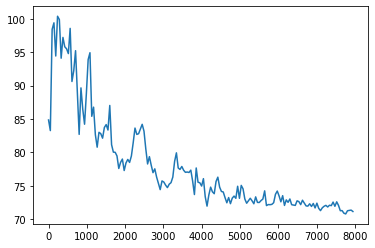

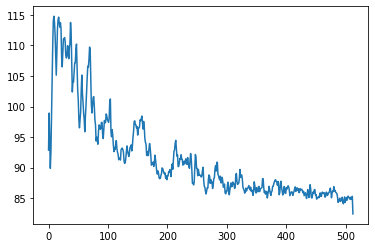

In [12]:
def calcWelch(Audiodata, fs, windowSize):
    """
    welch is an estimation of spectral power density
    beside being an estimation of spectral power, it help
    us to investigate the spectral power, simpler for
    future processes
    """
    freq, mag = calcSpectrum(Audiodata, fs, FreqRange=None, showPlot=False)
    # lower dense frequncy data
    mag2 = np.zeros(len(mag) // windowSize)
    freq2 = np.zeros(len(freq) // windowSize)
    for i in range(len(mag2)):
        mag2[i] = np.mean(
            [mag[int(i * (windowSize - 1) + r0)] for r0 in range(windowSize)]
        )
        freq2[i] = freq[int(i * windowSize)]
    return freq2, mag2

##
freq2, mag2 = calcWelch(noisyAudio, fs, 200)
plt.plot(freq2, 10 * np.log10(mag2 * window.sum() ** 2))
##
plt.figure()
power = (
    welch(noisyAudio, window=window, return_onesided=True, scaling="spectrum")[1]
    * window.sum() ** 2
)
plt.plot(10 * np.log10(power))
